In [1]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def add_random_noise(x):
    x = x + np.random.normal(size=x.shape) * np.random.uniform(1, 5)
    x = x - x.min()
    x = x / x.max()
    return x * 255.0

In [3]:
TRAINING_DIR = "C:/Users/2019A00298/dataset/train-set"
VALIDATION_DIR = "C:/Users/2019A00298/dataset/test-set"
batch_size = 10

In [4]:
# Image Data Generator with Augmentation

training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.5, 1.2),
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=add_random_noise
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [20]:
# Reading images from directory and pass them to the model

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=batch_size,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=batch_size,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,  # For evaluation
)

Found 93 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


type of img:  <class 'numpy.ndarray'>
img.shape:  (10, 224, 224, 3)
type of label:  <class 'numpy.ndarray'>
label.shape:  (10, 3)


C:\Users\2019A00298\anaconda3\envs\capstone\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


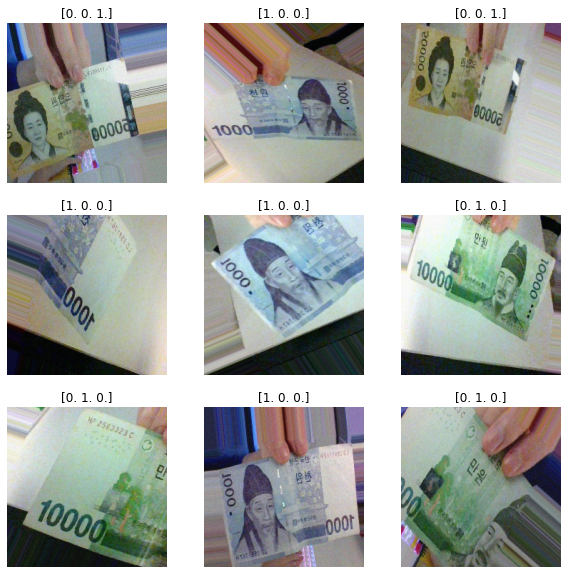

In [21]:
# Plotting the augmented imaged

img, label = next(train_generator)
print("type of img: ", type(img))
print("img.shape: ", img.shape)
print("type of label: ", type(label))
print("label.shape: ", label.shape)

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(img[i])
    plt.title(label[i])
    plt.axis('off')

plt.show()

In [7]:
# Load pre-trained base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
# Unfreeze the base model
base_model.trainable = True

In [8]:
# Freeze the base model except the last layer of unfeeze_n_layer
unfreeze_n_layer = 10
for i in range(0, len(base_model.layers) - unfreeze_n_layer):
    base_model.layers[i].trainable = False

In [9]:
# Add custom layers
out_layer = tf.keras.layers.Conv2D(128, (1, 1), padding='SAME', activation=None)(base_model.output)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.ReLU()(out_layer)
out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.Dense(3, activation='softmax')(out_layer)

In [10]:
# Make new model
model = tf.keras.models.Model(base_model.input, out_layer)

In [11]:
# Set lower learning rate for fine tuning
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Fine tuning
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/30
10/10 [==============================] - 6s 405ms/step - loss: 0.8209 - accuracy: 0.6237 - val_loss: 2.5518 - val_accuracy: 0.3667
Epoch 2/30
10/10 [==============================] - 3s 331ms/step - loss: 0.2955 - accuracy: 0.9247 - val_loss: 4.0630 - val_accuracy: 0.4000
Epoch 3/30
10/10 [==============================] - 3s 329ms/step - loss: 0.1739 - accuracy: 0.9677 - val_loss: 1.5503 - val_accuracy: 0.6667
Epoch 4/30
10/10 [==============================] - 4s 371ms/step - loss: 0.1770 - accuracy: 0.9677 - val_loss: 4.6173 - val_accuracy: 0.6000
Epoch 5/30
10/10 [==============================] - 4s 405ms/step - loss: 0.1721 - accuracy: 0.9462 - val_loss: 4.2532 - val_accuracy: 0.6667
Epoch 6/30
10/10 [==============================] - 4s 403ms/step - loss: 0.1343 - accuracy: 0.9785 - val_loss: 6.2890 - val_accuracy: 0.6333
Epoch 7/30
10/10 [==============================] - 4s 404ms/step - loss: 0.2108 - accuracy: 0.9247 - val_loss: 5.3238 - val_accuracy: 0.6667
Epoch 

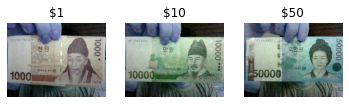

After resize and norm, imgae.shape:  (1, 224, 224, 3)


In [12]:
import glob
import cv2

INPUT_SIZE = (224, 224)
labels = np.array(['$1', '$10', '$50'])

images = [cv2.imread(file, cv2.IMREAD_COLOR) for file in glob.glob("C:/Users/2019A00298/test_img_before_make_model/*.jpg")]

plt.figure()
for i in range(len(images)):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

plt.show()

for i in range(len(images)):
    images[i] = cv2.resize(images[i], dsize=INPUT_SIZE, interpolation=cv2.INTER_AREA)
    images[i] = np.expand_dims(images[i], axis=0) / 255.0

print('After resize and norm, imgae.shape: ', images[0].shape)

In [13]:
for i in range(len(images)):
    classes = model.predict(images[i])
    answer = labels[np.argmax(classes)]
    print(f'Predict image[{i}]')
    print(f'answer is: {answer}\n')


Predict image[0]
answer is: $1

Predict image[1]
answer is: $10

Predict image[2]
answer is: $1



In [14]:
# tf.saved_model.save(model, "C:/Users/2019A00298/Desktop/test_mobilenet_model/")
tf.saved_model.save(model, "C:/Users/2019A00298/Desktop/model_for_ppt")

INFO:tensorflow:Assets written to: C:/Users/2019A00298/Desktop/model_for_ppt\assets


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

validation_generator.reset()
Y_pred = model.predict_generator(validation_generator, STEP_SIZE_VALID+1) #validation_generator.n // validation_generator.batch_size+1)
classes = validation_generator.classes[validation_generator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)  # Returns maximum indices in each row
print(sum(y_pred==classes)/10000)

C:\Users\2019A00298\anaconda3\envs\capstone\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.0029


In [39]:
class_names = ['$1', '$10', '$50']  # Alphanumeric order

print('-- Confusion Matrix without normalization --')
C = confusion_matrix(validation_generator.classes[validation_generator.index_array], y_pred)
print(C)


-- Confusion Matrix without normalization --
[[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]


In [40]:
C = C / C.astype(np.float).sum(axis=1)
print('-- Confusion Matrix with normalization --')
print(C)

-- Confusion Matrix with normalization --
[[1.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.1 0.9]]


In [37]:
report = classification_report(validation_generator.classes, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

          $1       1.00      1.00      1.00        10
         $10       0.91      1.00      0.95        10
         $50       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



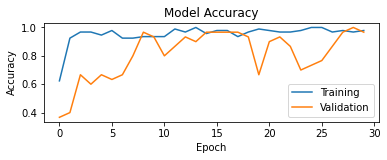

In [44]:
plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('Model Accuracy.png', dpi=300)

In [1]:
# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

plt.show()
plt.savefig('Model Loss.png', dpi=300)

NameError: name 'plt' is not defined